In [1]:
#______Standard Packages___________#
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pickle
%matplotlib inline
import multiprocessing as mp
from scipy.sparse import csr_matrix

#_________NLP specfic Packages_____________#

import requests #lets us leverage HTML code
from bs4 import BeautifulSoup #Web Scraper
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
import unicodedata
from keras.preprocessing.text import Tokenizer


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
#train data
base_path = "/home/nbatanay/.kaggle/quora-insincere-questions-classification/"
train_csv = pd.read_csv(base_path+"train.csv")

#test data
test_csv = pd.read_csv(base_path+"test.csv")

In [3]:
print(train_csv.shape)
train_csv.head()

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
print(test_csv.shape)
test_csv.head()

(56370, 2)


,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [5]:
#distribution of data
pd.concat([  
    train_csv["target"].value_counts().rename("counts"),
    train_csv["target"].value_counts(normalize=True).rename("percentage")], axis=1)

,counts,percentage
0,1225312,0.93813
1,80810,0.06187


In [6]:
#examples of insincere questions
insincere = train_csv[train_csv["target"]==1]
for q in insincere.iloc[np.random.randint(0, len(insincere), size=10)]["question_text"]:
    print(q)

Will being a cis-gendered, conservative, religious, white-male be illegal in the future?
Why don't conservatives trust the Democrat party? I know Hillary Clinton is bad, but so is Donald Trump.
Have we lost our sense of balance when it comes to Muslim rights?
Is violent homophobia actually homosexual in its thinking? After all, aren't people who engage in violence against homosexuals just advertising that they personally care how other men rub their penises in the privacy of their own homes?
Should I throw waste on the road in India as everybody does?
Is it possible to get Anna pics with cum on mouth to masturbate?
Why do Trump's lawyers tell us that Trump can't be prosecuted for obstruction of justice when that clearly implies that he, in fact, is guilty of obstruction of justice?
Why does the queen in Britain always wear such shitty clothing?
Why don't Vietnamese people realize that their country is just China's colony?
Why do feminists condemn men for slut shaming when it is done pr

In [7]:
#example of neutral questions
sincere = train_csv[train_csv["target"]==0]
for q in sincere.iloc[np.random.randint(0, len(insincere), size=10)]["question_text"]:
    print(q)

What do you mean by intensity?
Woh can cancel my IRCTC id?
Which is better way to ask? " Do you have a pet? " or " Do you have any pets?"
Will there be bottleneck if I use a FX-6300 with a Geforce GTX 1060?
Where are my old Google pictures?
What could be a good conversation with a beautiful girl sitting in front of you on a train journey?
How is Dynamic 365 team at Microsoft IDC Hyderabad?
On which ground I stop the minor child to claim their parent property in a suit?
Why are the curtains and bedsheets at my home releasing electric shocks and sparks?
What could be the best possible way to kill boredom when I have no idea what to do?


count    1.306122e+06
mean     1.280350e+01
std      7.052138e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.500000e+01
max      1.220000e+02
dtype: float64

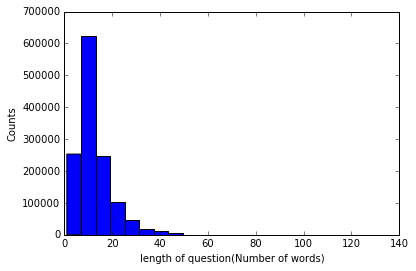

In [8]:
#how long a question is, on average?
sentence_length = \
train_csv["question_text"].apply(lambda x: x.split(" "))\
                          .apply(lambda x: len(x))\
                          .values

_ = plt.hist(sentence_length, bins=20)
plt.xlabel("length of question(Number of words)")
plt.ylabel("Counts")

pd.Series(sentence_length).describe()

In [9]:
#load the contractions 
contractions_map = pd.read_pickle("../nlp_training/CONTRACTION_MAP.pickle")

#load the stopwords
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

#load the spacy model
spacy_mod = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)

#tokenizer 
tokenizer = ToktokTokenizer()

def remove_accented_chars(text):
    """
    Removes the accented characters and replaces them 
    with ascii values counterparts.
    INPUT:
        text: <str>
    """
    text = unicodedata.normalize('NFKD', text)\
                      .encode('ascii', 'ignore')\
                      .decode('utf-8', 'ignore')
    return text

def strip_html_tags(text):
    """
    Removes the html tags.
    INPUT:
        text: <str>
    """
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def expand_contractions(text, contraction_mapping=contractions_map):
    """
    Expands common phrase contractions.
    INPUT:
        text: <str> text to look for contractions and expand them
        contractions_map: <dict> containing the keys as the contractions 
                                and values the expanded versions 
    """
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_special_characters(text, remove_digits=False):
    """
    Removes the special characters from the text
    INPUT:
        text: <str> text to remove special characters
        remove_digit: <bool> option to remove the number digits 
                            in the text
    """
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_stopwords(text, stopword_list, tokenizer, is_lower_case=False):
    """
    Removes the stopwords from the text 
    given a list of stopwords.
    INPUT:
        text: <str> text to remove the stopwords
        stopword_list: <list> containing the stopwords
        tokenizer: <python object> with tokenize() method that transforms
                        text to a list/iterable of tokens/words.
    """
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def lemmatize_text(text, nlp_mod=spacy_mod):
    """
    Transform the words/tokens to its root word.
    INPUT:
        text: <str> text to lemmatize
        spacy_model: <spacy object>
        
    """
    text = nlp_mod(text)
    text = ' '.join([word.lemma_ if (word.ent_iob_ == "O" and word.lemma_ != "-PRON-")
                     else word.text for word in text])
    return text


def text_preproc(text, html_stripping=True, contraction_expansion=True,
                 accented_char_removal=True, text_lower_case=False, 
                 text_lemmatization=True, special_char_removal=True, 
                 stopword_removal=False, remove_digits=True,
                 stopword_list=stopword_list, tokenizer=tokenizer):
    
    """
    Preprocess the text data.
    """
    
    # strip HTML
    if html_stripping:
        text = strip_html_tags(text)
    # remove accented characters
    if accented_char_removal:
        text = remove_accented_chars(text)
    # expand contractions    
    if contraction_expansion:
        text = expand_contractions(text)
    # lowercase the text    
    if text_lower_case:
        text = text.lower() #Standard text lower method
    # remove extra newlines
    text = re.sub(r'[\r|\n|\r\n]+', ' ', text)
    # lemmatize text
    if text_lemmatization:
        text = lemmatize_text(text)
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        text = special_char_pattern.sub(" \\1 ", text)
        text = remove_special_characters(text, remove_digits=remove_digits)  
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    # remove stopwords
    if stopword_removal:
        text = remove_stopwords(text, stopword_list, tokenizer, is_lower_case=text_lower_case)
    
    return tokenizer.tokenize(text)

In [10]:
#show an example of preprocessing
ind = 617
(text_preproc(train_csv["question_text"].iloc[ind], text_lower_case=False), 
 train_csv["question_text"].iloc[ind],
 train_csv["target"].iloc[ind])

(['when',
  'will',
  'the',
  'US',
  'stop',
  'support',
  'Kosovo',
  'terrorist',
  'Albanians',
  'who',
  'be',
  'actually',
  'the',
  'same',
  'as',
  'ISIS'],
 'When will the US stop supporting Kosovo terrorists (Albanians), who are actually the same as ISIS?',
 1)

In [11]:
%%time
pool = mp.Pool(processes=mp.cpu_count()-3)
train_csv["preproc"] = pd.Series(pool.map(text_preproc, train_csv["question_text"].values))
pool.close()

train_csv.head()

CPU times: user 15.6 s, sys: 6.49 s, total: 22.1 s
Wall time: 19min 17s


In [12]:
train_csv.head()

,qid,question_text,target,preproc
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,"[how, do, Quebec, nationalist, see, their, pro..."
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"[do, you, have, an, adopt, dog, how, would, yo..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,"[why, do, velocity, affect, time, do, velocity..."
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,"[how, do, Otto, von, Guericke, use, the, Magde..."
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,"[can, I, convert, montra, helicon, d, to, a, m..."


In [13]:
%%time
#let's assign numeric codes per word 
num_words = 50000 #let's consider only the top 50000 words 
keras_tokenizer = Tokenizer(num_words=num_words)

keras_tokenizer.fit_on_texts(train_csv["preproc"].values)
train_csv["num_codes"] = keras_tokenizer.texts_to_sequences(train_csv["preproc"].values)

In [14]:
train_csv.head()

,qid,question_text,target,preproc,num_codes
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,"[how, do, Quebec, nationalist, see, their, pro...","[10, 4, 5352, 4049, 109, 52, 4131, 34, 5, 755,..."
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"[do, you, have, an, adopt, dog, how, would, yo...","[4, 13, 16, 29, 1625, 305, 10, 32, 13, 2333, 3..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,"[why, do, velocity, affect, time, do, velocity...","[15, 4, 1835, 267, 61, 4, 1835, 267, 445, 4570]"
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,"[how, do, Otto, von, Guericke, use, the, Magde...","[10, 4, 10270, 6775, 41348, 43, 2, 31422, 6733]"
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,"[can, I, convert, montra, helicon, d, to, a, m...","[14, 9, 781, 33887, 568, 6, 5, 2140, 1232, 46,..."


In [16]:
X_train = pad_sequences(train_csv["num_codes"])